In [1]:
import numpy as np
import ase.io
import tqdm
from nice.blocks import *
from nice.utilities import *
from matplotlib import pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Ridge
from rascal.utils import (get_radial_basis_covariance, get_radial_basis_pca, 
                          get_radial_basis_projections, get_optimal_radial_basis_hypers )
from nice.rascal_coefficients import process_structures

In /home/pozdn/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/pozdn/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/pozdn/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/pozdn/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/pozdn/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

In [2]:
HARTREE_TO_EV = 27.211386245988
FORCE_FACTOR = 51.42208619083232
train_subset = "0:20000"  #input for ase.io.read command
test_subset = '20000:25000'  #input to ase.io.read command
environments_for_fitting = 20000 #number of environments to fit nice transfomers
GRID =  [150, 200, 350, 500, 750, 1000, 1500, 2000, 3000,
          5000, 7500, 10000, 15000, 20000] #for learning curve

#HYPERS for librascal spherical expansion coefficients
LAMBDA_MAX = 4
HYPERS = {
    'interaction_cutoff': 3.5,
    'max_radial': 4,
    'max_angular': LAMBDA_MAX,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.05,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'GTO'
}
MAGIC_NUMBER = 1.0 / 0.0001892813597805798
BATCH_SIZE = 500

train_structures = process_structures(ase.io.read('../methane.extxyz', index=train_subset))
'''HYPERS = get_optimal_radial_basis_hypers(HYPERS,
                                       train_structures,
                                       expanded_max_radial=50)'''
test_structures = process_structures(ase.io.read('../methane.extxyz', index=test_subset))

all_species = get_all_species(train_structures + test_structures)

train_energies = [structure.info['energy'] for structure in train_structures]
train_energies = np.array(train_energies) * HARTREE_TO_EV
e_mean = np.mean(train_energies)
train_energies -= e_mean

test_energies = [structure.info['energy'] for structure in test_structures]
test_energies = np.array(test_energies) * HARTREE_TO_EV
test_energies -= e_mean
print(np.min(train_energies), np.max(train_energies))

-10.345616788887583 29.021351564031193


In [3]:
#our model:
def get_nice():
    return StandardSequence([
        StandardBlock(ThresholdExpansioner(num_expand = 500),
                      None,
                      IndividualLambdaPCAsBoth(n_components=50),
                      ThresholdExpansioner(num_expand = 1500, mode = 'invariants'),
                      None,
                      InvariantsPCA(n_components = 50)),
        StandardBlock(ThresholdExpansioner(num_expand = 500),
                      None,
                      IndividualLambdaPCAsBoth(n_components=50),
                     ThresholdExpansioner(num_expand = 1500, mode = 'invariants'),
                      None,
                      InvariantsPCA(n_components = 50)),
        StandardBlock(ThresholdExpansioner(num_expand = 500),
                      None,
                      IndividualLambdaPCAsBoth(n_components=50),
                      ThresholdExpansioner(num_expand = 1500, mode = 'invariants'),
                      None,
                      InvariantsPCA(n_components = 50)),
       
    ],
                           )

In [4]:
train_coefficients = get_spherical_expansion(train_structures, HYPERS,
                                             all_species)

test_coefficients = get_spherical_expansion(test_structures, HYPERS,
                                            all_species)

for key in train_coefficients.keys():
    train_coefficients[key] *= MAGIC_NUMBER
    test_coefficients[key] *= MAGIC_NUMBER



100%|██████████| 2/2 [00:00<00:00, 67.10it/s]


In [5]:
nice = get_nice()
np.random.seed(0)
nice.fit(train_coefficients[6][:environments_for_fitting])

In [6]:
def get_features(nice, coefs):
    features = {}
    for i in range(0, coefs.shape[0], BATCH_SIZE):
        now = nice.transform(coefs[i : i + BATCH_SIZE], return_only_invariants = True)
        for key in now.keys():
            if key in features.keys():
                features[key].append(now[key])
            else:
                features[key] = [now[key]]
    for key in features.keys():
        features[key] = np.concatenate(features[key], axis = 0)
    return features

In [7]:
train_features = get_features(nice, train_coefficients[6])
test_features = get_features(nice, test_coefficients[6])
for key in train_features.keys():
    print(train_features[key].shape)

(20000, 8)
(20000, 50)
(20000, 50)
(20000, 50)


In [8]:
def get_rmse(first, second):
    return np.sqrt(np.mean((first - second)**2))


def get_standard_deviation(values):
    return np.sqrt(np.mean((values - np.mean(values))**2))


def get_relative_performance(predictions, values):
    return get_rmse(predictions, values) / get_standard_deviation(values)


def estimate_performance(regressor, data_train, data_test, targets_train,
                         targets_test):
    regressor.fit(data_train, targets_train)
    return get_relative_performance(regressor.predict(data_test), targets_test)

def get_lr(regressor, data_train, data_test, targets_train,
           targets_test):
    result = []
    for el in GRID:
        result.append(estimate_performance(regressor, data_train[:el], data_test,
                                           targets_train[:el], targets_test))
    return result

(20000, 8)
(20000, 58)
(20000, 108)
(20000, 158)


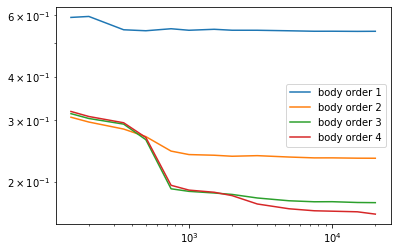

In [9]:
for index in range(1, 5):
    train = [train_features[i] for i in range(1, index + 1)]
    test = [test_features[i] for i in range(1, index + 1)]
    train = np.concatenate(train, axis = 1)
    test = np.concatenate(test, axis = 1)
    print(train.shape)
    lr = get_lr(BayesianRidge(), train, test, train_energies, test_energies)
    plt.plot(GRID, lr, label = "body order {}".format(index))
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [10]:
print(lr)

[0.3181373846548951, 0.30775174865984517, 0.29529693266160034, 0.26794536261405555, 0.1954519447744216, 0.18935240533145964, 0.1866751694642882, 0.18259329150968565, 0.17277856721785972, 0.16740282578210117, 0.16521483243916305, 0.16475365986539534, 0.16409701580761626, 0.1616050422529275]


In [11]:
for key in train_features.keys():
    print(key, train_features[key].shape, np.mean(np.sum(train_features[key] * train_features[key], axis = 1)))

1 (20000, 8) 0.5442384952797239
2 (20000, 50) 0.042630350555598946
3 (20000, 50) 0.1139468799706588
4 (20000, 50) 0.24200286324022496
